/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Loading MNIST dataset...
Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(48999, 784) (10500, 784) (10501, 784) float64
(48999,) (10500,) (10501,) int64


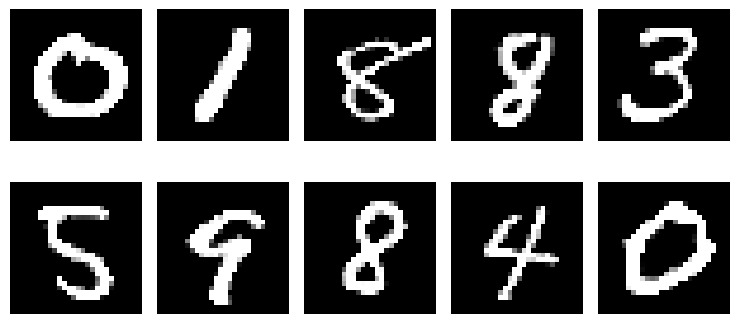

[I 2025-10-29 21:29:02,783] A new study created in memory with name: no-name-d6930943-81dd-444d-9106-247dfd76885d


Epoch [5/40] | Train Loss: 0.6542 - Val Loss: 0.2601
Epoch [10/40] | Train Loss: 0.5982 - Val Loss: 0.2362
Epoch [15/40] | Train Loss: 0.5944 - Val Loss: 0.2195
Epoch [20/40] | Train Loss: 0.6313 - Val Loss: 0.2317
Epoch [25/40] | Train Loss: 0.6139 - Val Loss: 0.2090
Epoch [30/40] | Train Loss: 0.6191 - Val Loss: 0.2428
Epoch [35/40] | Train Loss: 0.5984 - Val Loss: 0.2196
Early stopping triggered.


[I 2025-10-29 21:32:01,860] Trial 0 finished with value: 0.2229497068712399 and parameters: {'n_layers': 5, 'n_units_l0': 82, 'n_units_l1': 160, 'n_units_l2': 143, 'n_units_l3': 159, 'n_units_l4': 203, 'lr': 0.08524056719402073, 'batch_size': 32, 'dropout_l0': 0.128101040822597, 'dropout_l1': 0.0957427232594057, 'dropout_l2': 0.3816994517860834, 'dropout_l3': 0.07513336962009082, 'dropout_l4': 0.3384653470861062, 'weight_decay': 5.409967781178296e-05, 'optimizer': 'adam', 'stopping_patience': 8, 'activation_l0': 'sigmoid', 'activation_l1': 'tanh', 'activation_l2': 'relu', 'activation_l3': 'tanh', 'activation_l4': 'relu', 'step_size': 11.143148705787441, 'gamma': 0.31571269498056137}. Best is trial 0 with value: 0.2229497068712399.


Best trial:
  Value: 0.2229
  Params:
    n_layers: 5
    n_units_l0: 82
    n_units_l1: 160
    n_units_l2: 143
    n_units_l3: 159
    n_units_l4: 203
    lr: 0.08524056719402073
    batch_size: 32
    dropout_l0: 0.128101040822597
    dropout_l1: 0.0957427232594057
    dropout_l2: 0.3816994517860834
    dropout_l3: 0.07513336962009082
    dropout_l4: 0.3384653470861062
    weight_decay: 5.409967781178296e-05
    optimizer: adam
    stopping_patience: 8
    activation_l0: sigmoid
    activation_l1: tanh
    activation_l2: relu
    activation_l3: tanh
    activation_l4: relu
    step_size: 11.143148705787441
    gamma: 0.31571269498056137


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch [5/40] | Train Loss: 0.6566 - Val Loss: 0.2951
Epoch [10/40] | Train Loss: 0.6001 - Val Loss: 0.2394
Epoch [15/40] | Train Loss: 0.5809 - Val Loss: 0.2514
Epoch [20/40] | Train Loss: 0.5557 - Val Loss: 0.2218
Epoch [25/40] | Train Loss: 0.5495 - Val Loss: 0.2251
Epoch [30/40] | Train Loss: 0.5378 - Val Loss: 0.2323
Early stopping triggered.


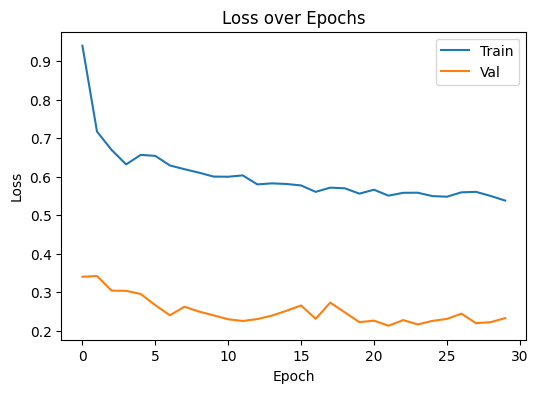

Test Accuracy: 94.96%


In [ ]:
# ===============================
# Deep Neural Network using PyTorch made faster
# Dataset: MNIST (Handwritten Digit Recognition)
# ===============================

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from functools import partial
import optuna
from typing import List, Optional, Tuple
from dataclasses import dataclass
from tqdm import tqdm

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    torch.set_float32_matmul_precision('high')
else:
    torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(RNG_SEED)

#  Mixed Precision & Dataloader Settings
USE_AMP = torch.cuda.is_available()   # enable AMP only if GPU is available
PIN_MEMORY = torch.cuda.is_available()  # pin_memory only makes sense on GPU


# =======================================
# 1. Load and Preprocess Data
# =======================================
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sizes must sum to 1"

    # First split: train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=random_state, stratify=y)

    # Compute proportion of validation relative to temp
    val_prop = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_prop), random_state=random_state, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Usage:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)
print(X_train.shape, X_val.shape, X_test.shape,  X_train.dtype)
print(y_train.shape, y_val.shape, y_test.shape,  y_train.dtype)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
show_images(X_train)


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tensor_dataset(X,y):
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X_tensor, y_tensor)

def make_dataloaders(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      pin_memory=PIN_MEMORY, 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

# Datasets
train_dataset = df_to_tensor_dataset(X_train, y_train)
val_dataset = df_to_tensor_dataset(X_val, y_val)
test_dataset = df_to_tensor_dataset(X_test, y_test)


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    momentum: float = 0.9
    optimizer_type: str = "adam"
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = USE_AMP


# =======================================
# 5. Model Definition
# =======================================
class DeepNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        super().__init__()
        layers = []
        prev = input_dim
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * n_hidden
        if dropout_rates is None:
            dropout_rates = [0.0] * n_hidden
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            if act_ctor is None and act_name != "softmax_logit":
                raise ValueError(f"Unsupported activation: {act_name}")
            if act_ctor is not None:
                layers.append(act_ctor())
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                layers.append(nn.Dropout(dropout_rates[idx]))
            prev = h
        
        # Output layer (no activation here if using CrossEntropy)
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

        self._init_weights(activations)

    def _init_weights(self, activations: List[str]):
        idx_hidden = 0
        for m in self.net:
            if isinstance(m, nn.Linear):
                # choose activation of the incoming layer index
                act = activations[idx_hidden] if idx_hidden < len(activations) else None
                if act in ("relu", "leaky_relu"):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu") # He init
                else:
                    nn.init.xavier_normal_(m.weight) # Xavier init
                nn.init.zeros_(m.bias)
                idx_hidden += 1

    def forward(self, x):
        return self.net(x)
    

# =======================================
# 6. Training Loop
# =======================================
def train_model(
    train_dataset, val_dataset,
    input_dim, output_dim,
    config: TrainConfig,
    print_every=10, plot_loss=False
):  
    # Data preparation
    train_loader = make_dataloaders(train_dataset, config.batch_size, shuffle=True)
    val_loader = make_dataloaders(val_dataset, config.batch_size, shuffle=False)

    # Model creation
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    model = DeepNN(input_dim, config.hidden_layers, output_dim, config.activations, config.dropout_rates)
    model.to(device)
    model = torch.compile(model) # if no C++ available add: , backend="aot_eager")

    if config.optimizer_type.lower() == "adam": # AdamW is the fastest and more stable option generally
        optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    elif config.optimizer_type.lower() in ("sgd", "momentum"):
        optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
    else:
        raise ValueError("Unsupported optimizer_type")
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    criterion = nn.CrossEntropyLoss() if config.loss_function == "cross_entropy" else nn.MSELoss()
    scaler = torch.amp.GradScaler(enabled=config.use_amp)

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device.type, enabled=config.use_amp):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            scaler.scale(loss).backward()
            if config.clip_grad_norm:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch = X_val_batch.to(device, non_blocking=True)
                y_val_batch = y_val_batch.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type, enabled=config.use_amp):
                    outputs_val = model(X_val_batch)
                    loss_val = criterion(outputs_val, y_val_batch)
                val_loss += loss_val.item() * X_val_batch.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

         # Early stopping
        if config.early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print("Early stopping triggered.")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    if plot_loss:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Val")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model


# =======================================
# 7. Prediction & Evaluation
# =======================================
# Prediction function for any DataLoader
def predict_loader(model, loader, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    
    all_probs, all_preds, all_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    return (
        torch.cat(all_preds).numpy(),
        torch.cat(all_probs).numpy(),
        torch.cat(all_targets).numpy(),
    )

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(trial, loss_function="cross_entropy", epochs=40):
    # Hyperparameters to search
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 64, 256) for i in range(n_layers)]
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5) for i in range(n_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_type = trial.suggest_categorical("optimizer", ["sgd", "momentum", "adam"])
    stopping_patience = trial.suggest_int("stopping_patience", 3, 10)
    # Activation functions per layer
    possible_activations = ["relu", "sigmoid", "tanh", "leaky_relu"]
    activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_layers)]
    momentum = 0.0
    if optimizer_type in ["sgd", "momentum"]:
        momentum = trial.suggest_float("momentum", 0.0, 0.9)
    step_size = trial.suggest_float("step_size", 10, 20, log=True)
    gamma = trial.suggest_float("gamma", 0.25, 0.5, log=True)

    config = TrainConfig(
        hidden_layers=hidden_layers, 
        activations=activations, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        momentum=momentum, 
        optimizer_type=optimizer_type, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=USE_AMP
    )

    model = train_model(
        train_dataset, val_dataset,
        input_dim, output_dim,
        config,
        print_every=5, plot_loss=False
    )

    # Validation loss
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model.eval()
    criterion = nn.CrossEntropyLoss() if loss_function == "cross_entropy" else nn.MSELoss()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val_batch in val_loader:
            x_val, y_val_batch = x_val.to(device), y_val_batch.to(device)
            logits = model(x_val)
            val_loss += criterion(logits, y_val_batch).item() * x_val.size(0)
    val_loss /= len(val_loader.dataset)
    return val_loss

# Run Optuna study
loss_function = "cross_entropy"
epochs = 40
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=1)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_layers = best_params["n_layers"]
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_layers)]
weight_decay = best_params["weight_decay"]
optimizer_type = best_params["optimizer"]
stopping_patience = best_params["stopping_patience"]
activations = [best_params[f"activation_l{i}"] for i in range(n_layers)]
momentum = best_params.get("momentum", 0.0)  # default 0.0 if not present
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    hidden_layers=hidden_layers, 
    activations=activations, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs, 
    weight_decay=weight_decay, 
    momentum=momentum, 
    optimizer_type=optimizer_type, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model = train_model(
    train_dataset, val_dataset,
    input_dim, output_dim,
    config,
    print_every=5, plot_loss=True
)

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)
y_pred_test, _, _ = predict_loader(best_model, test_loader, device)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")